# Lecture 8

notes for the code: the program is similar to the one from the previous lecture, without the file <font face="Courier">input.dat</font> and with variables declared at the beginning of <font face="Courier">es8_1.cpp</font>.

We want to find the ground state of a 1D quantum particle with Hamiltonian
$$H(p,q)=\dfrac{p^2}{2m}+q^4-\dfrac{5}{2}q^2$$
since the problem is non analitically solvable, we will use numerical methods: Variational Monte Carlo (VMC), Path Integral Monte Carlo (PIGS) and numerical diagonalization.

## Execises 8.1 and 8.2: Variational Monte Carlo

Variational priciple states that, for any trial wave function $\psi_T(a)$, holds
$$\langle H \rangle_T=\dfrac{<\psi_T(a)|H|\psi_T(a)>}{<\psi_T(a)|\psi_T(a)>} \geq E_0=\dfrac{<\psi_0|H|\psi_0>}{<\psi_0|\psi_0>}$$
where $E_0$ and $\psi_0$ are the actual ground state energy and wave function of the problem and $a$ is a set of parameters that can be adjusted. Here we will use
$$\psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$$
and we want to optimize the two parameters to find the minumim.

We make 500 optimization "cycles", with starting parameters $(x;\mu;\sigma)=(1; 0,8; 1)$ and steps $(dx; d\mu; d\sigma)=(2; 1; 1)$ ($p^{(i)}\in[p^{(i-1)}-dp;p^{(i-1)}+dp]$). The cycle is the usual simulation, with 200 blocks of 1000 steps. At the end the cycle, we compare the last value for $\langle H \rangle_T$ with the last value from the previous one: if $\langle H \rangle_T^{(i)} < \langle H \rangle_T^{(i-1)}$, we accept the new parameters $\mu$ and $\sigma$ and halve their steps, else we keep the old ones. At the end of the optimization process we get $\mu=0,7875$, $\sigma=0,6294$.

### ground state energy

with those values we find $\langle H \rangle_T=-0,393$, while diagonalizing numerically the matrix we get $E_0=-0.460$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
mu=0.798
sigma=0.629

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 6
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)


#print("Ground state energy: ", E[0])
#print("1st excited state energy: ", E[1])
#print("2nd excited state energy: ", E[2])

# Plot a few things
#plt.figure(figsize=(8,5))
#scale = 0.3
#plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
#plt.plot(x,(psi[0])**2, label="GS")
#plt.plot(x,(psi[1])**2, label="I")
#plt.plot(x,(psi[2])**2, label="II")
#plt.title("Potential & Probabilities")
#plt.xlabel("x")
#plt.grid(True)
#plt.xlim((-3,3))
#plt.ylim((-0.6,0.6))
#plt.legend(loc='lower right')
#plt.show()

Ground state energy:  -0.46045845079911835
VMC ground state energy:  -0.39318


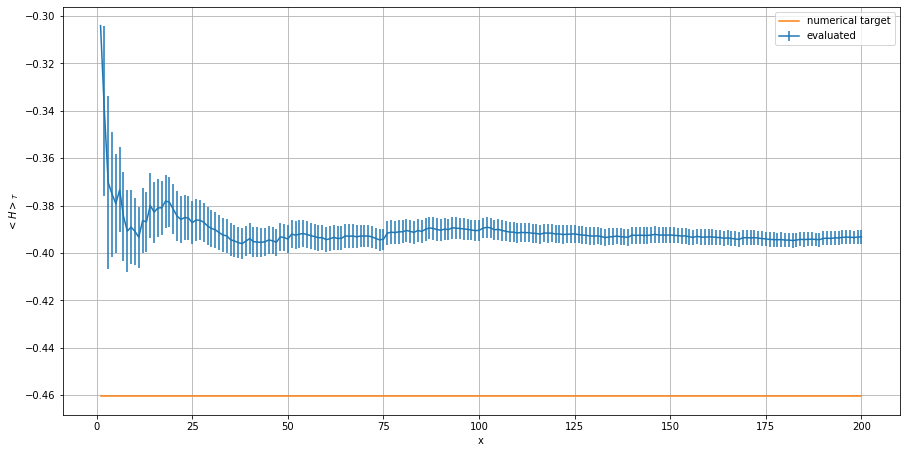

In [17]:
block,H,H_err=np.loadtxt("es8.1/output.etot.0", usecols=(0,2,3), delimiter=" ", unpack='true')
print("Ground state energy: ", E[0])
print("VMC ground state energy: ", H[-1]) 

target=np.zeros(len(block))
for i in range(len(block)):
    target[i]=E[0]
plt.figure(0,figsize=(15,7.5))
plt.errorbar(block,H,yerr=H_err,label='evaluated')
plt.plot(block,target,label='numerical target')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$<H>_T$")
plt.grid(True)
plt.show()

### probability distribution

we compare the probability distribution $|\psi_T^{\mu,\sigma}|^2$, both "theoretical" and sampled, with the numerical solution. We also include the PIGS results from the following section. We can see that PIGS and numerical probability distributions are nearly identical, while differing whith VMC ones.

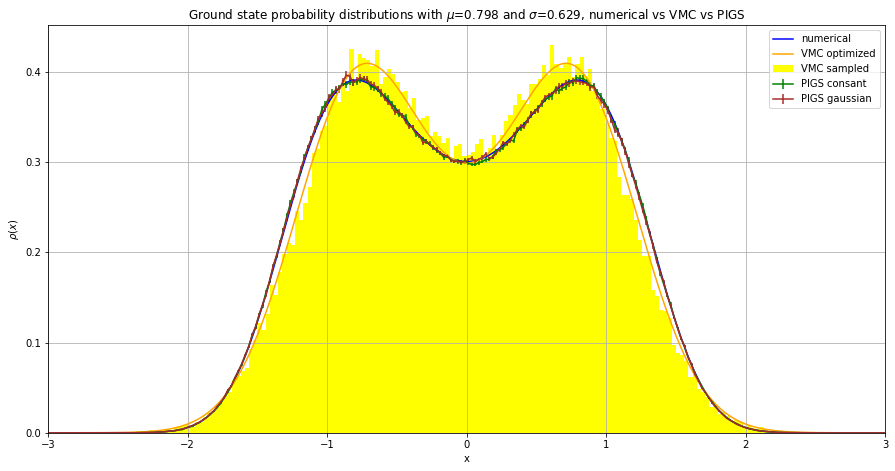

In [18]:
def psiT(x):
    t1=((x-mu)/sigma)**2
    t2=((x+mu)/sigma)**2
    return np.exp(-t1/2)+np.exp(-t2/2)

psiVMC=np.loadtxt("es8.1/pos.0", usecols=(0), unpack='true')
x_const,psi_const,err_const=np.loadtxt("es8.3/pigs_const/probability_t8.dat", usecols=(0,1,2), unpack='true')
x_gauss,psi_gauss,err_gauss=np.loadtxt("es8.3/pigs_gauss/probability_t8.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))
bins=200
psi_opt=(psiT(x))**2
N=np.sum(dx*psi_opt)

plt.plot(x,(psi[0])**2, label='numerical', color='blue')
plt.hist(psiVMC,bins,range=(-3,3),label='VMC sampled',density='true',color='yellow')
plt.plot(x,psi_opt/N, label='VMC optimized', color='orange')
plt.errorbar(x_const,psi_const,yerr=err_const,label='PIGS consant', color='green')
plt.errorbar(x_gauss,psi_gauss,yerr=err_gauss,label='PIGS gaussian', color='brown')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$\rho(x)$")
plt.title(f"Ground state probability distributions with $\mu$={mu} and $\sigma$={sigma}, numerical vs VMC vs PIGS")
plt.xlim((-3,3))
plt.grid(True)
plt.show()

## Exercise 8.3: Path Integral Monte Carlo

this methon can be used to obtain not only the ground state energy and wave function (PIGS), but also energy and wave function for mixture states (PIMC, $T>0$). The code can be used whith a constant wave function $\psi_T=1$ or with our gaussian-like $\psi_T^{\mu,\sigma}$. The groud states probability distribution for both the cases is shown above.

### ground state, diminishing imaginary time propagation

the default imaginary time propagation is $it=8$. We reduce this up to $it=1$, both for the constant and the gaussian wave functions and compare the probability distributions obtained. While $\psi_T^{\mu,\sigma}$ is still good at this point, $\psi_T=1$ shows some distrortions for $it=2$ and $it=1$.

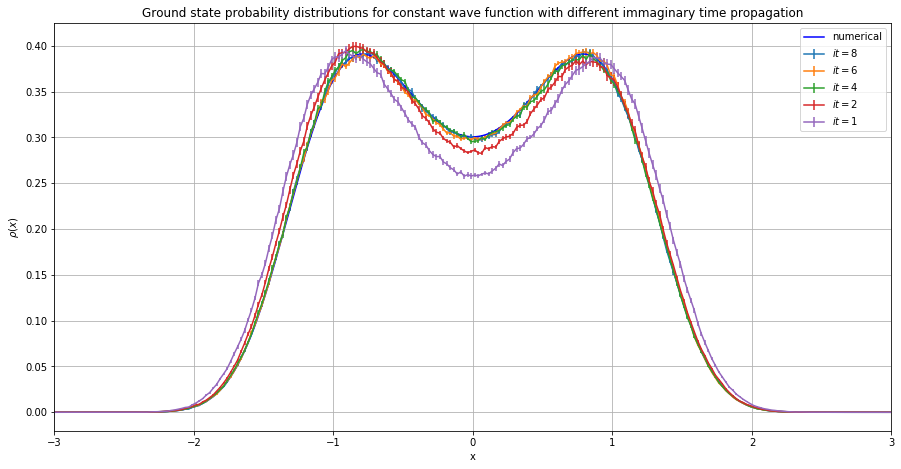

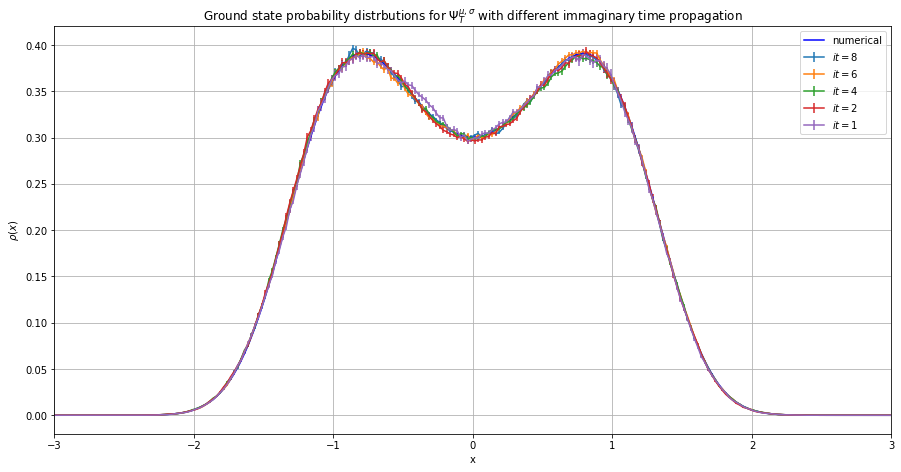

In [82]:
x_c8,psi_c8,err_c8=np.loadtxt("es8.3/pigs_const/probability_t8.dat", usecols=(0,1,2), unpack='true')
x_c6,psi_c6,err_c6=np.loadtxt("es8.3/pigs_const/probability_t6.dat", usecols=(0,1,2), unpack='true')
x_c4,psi_c4,err_c4=np.loadtxt("es8.3/pigs_const/probability_t4.dat", usecols=(0,1,2), unpack='true')
x_c2,psi_c2,err_c2=np.loadtxt("es8.3/pigs_const/probability_t2.dat", usecols=(0,1,2), unpack='true')
x_c1,psi_c1,err_c1=np.loadtxt("es8.3/pigs_const/probability_t1.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(x_c8,psi_c8,yerr=err_c8,label='$it=8$')
plt.errorbar(x_c6,psi_c6,yerr=err_c6,label='$it=6$')
plt.errorbar(x_c4,psi_c4,yerr=err_c4,label='$it=4$')
plt.errorbar(x_c2,psi_c2,yerr=err_c2,label='$it=2$')
plt.errorbar(x_c1,psi_c1,yerr=err_c1,label='$it=1$')
plt.plot(x,(psi[0])**2, label='numerical', color='blue')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$\rho(x)$")
plt.title(f"Ground state probability distributions for constant wave function with different immaginary time propagation")
plt.xlim((-3,3))
plt.grid(True)
plt.show()

x_g8,psi_g8,err_g8=np.loadtxt("es8.3/pigs_gauss/probability_t8.dat", usecols=(0,1,2), unpack='true')
x_g6,psi_g6,err_g6=np.loadtxt("es8.3/pigs_gauss/probability_t6.dat", usecols=(0,1,2), unpack='true')
x_g4,psi_g4,err_g4=np.loadtxt("es8.3/pigs_gauss/probability_t4.dat", usecols=(0,1,2), unpack='true')
x_g2,psi_g2,err_g2=np.loadtxt("es8.3/pigs_gauss/probability_t2.dat", usecols=(0,1,2), unpack='true')
x_g1,psi_g1,err_g1=np.loadtxt("es8.3/pigs_gauss/probability_t1.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(x_g8,psi_g8,yerr=err_g8,label='$it=8$')
plt.errorbar(x_g6,psi_g6,yerr=err_g6,label='$it=6$')
plt.errorbar(x_g4,psi_g4,yerr=err_g4,label='$it=4$')
plt.errorbar(x_g2,psi_g2,yerr=err_g2,label='$it=2$')
plt.errorbar(x_g1,psi_g1,yerr=err_g1,label='$it=1$')
plt.plot(x,(psi[0])**2, label='numerical', color='blue')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$\rho(x)$")
plt.title("Ground state probability distrbutions for $\Psi_T^{\mu,\sigma}$ with different immaginary time propagation")
plt.xlim((-3,3))
plt.grid(True)
plt.show()

### mixture states, increasing temperature

we start increasing the temperature at wich the simulations are made. The wave functions are now a superposition of the ground state and the I excited state, both shown in the following plot.

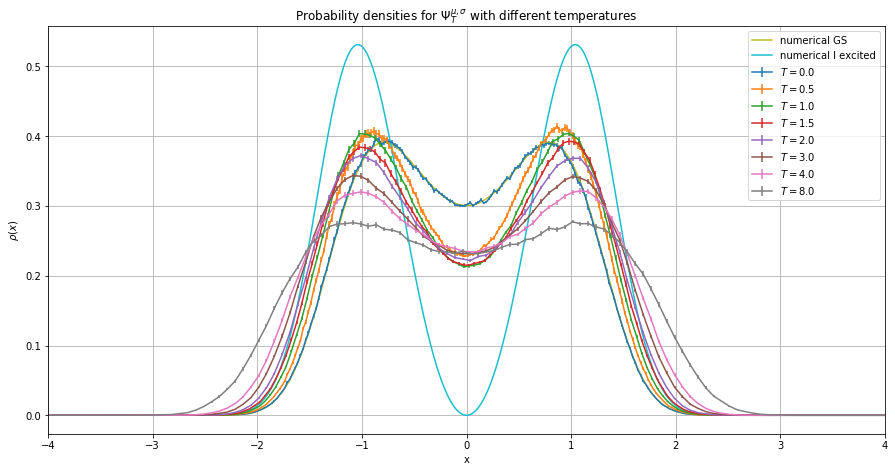

In [86]:
x_00,psi_00,err_00=np.loadtxt("es8.3/pimc_gauss/probability_T00.dat", usecols=(0,1,2), unpack='true')
x_05,psi_05,err_05=np.loadtxt("es8.3/pimc_gauss/probability_T05.dat", usecols=(0,1,2), unpack='true')
x_10,psi_10,err_10=np.loadtxt("es8.3/pimc_gauss/probability_T10.dat", usecols=(0,1,2), unpack='true')
x_15,psi_15,err_15=np.loadtxt("es8.3/pimc_gauss/probability_T15.dat", usecols=(0,1,2), unpack='true')
x_20,psi_20,err_20=np.loadtxt("es8.3/pimc_gauss/probability_T20.dat", usecols=(0,1,2), unpack='true')
x_30,psi_30,err_30=np.loadtxt("es8.3/pimc_gauss/probability_T30.dat", usecols=(0,1,2), unpack='true')
x_40,psi_40,err_40=np.loadtxt("es8.3/pimc_gauss/probability_T40.dat", usecols=(0,1,2), unpack='true')
x_80,psi_80,err_80=np.loadtxt("es8.3/pimc_gauss/probability_T80.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(x_00,psi_00,yerr=err_00,label='$T=0.0$')
plt.errorbar(x_05,psi_05,yerr=err_05,label='$T=0.5$')
plt.errorbar(x_10,psi_10,yerr=err_10,label='$T=1.0$')
plt.errorbar(x_15,psi_15,yerr=err_15,label='$T=1.5$')
plt.errorbar(x_20,psi_20,yerr=err_20,label='$T=2.0$')
plt.errorbar(x_30,psi_30,yerr=err_30,label='$T=3.0$')
plt.errorbar(x_40,psi_40,yerr=err_40,label='$T=4.0$')
plt.errorbar(x_80,psi_80,yerr=err_80,label='$T=8.0$')
plt.plot(x,(psi[0])**2, label="numerical GS")
plt.plot(x,(psi[1])**2, label="numerical I excited")
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$\rho(x)$")
plt.title("Probability densities for $\Psi_T^{\mu,\sigma}$ with different temperatures")
plt.xlim((-4,4))
plt.grid(True)
plt.show()